In [6]:
import sys
print("python version: ", sys.version)

import pandas as pd
print("pandas version: ", pd.__version__)

import numpy as np
print('numpy version: ', np.__version__)

import scipy as sp
print('scipy version: ', sp.__version__)

import sklearn as skl
print('sklearn version: ', skl.__version__)

import matplotlib.pyplot as plt

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

import keras as ks
print('keras version: ', ks.__version__)
print('keras backend: ', ks.backend.backend())

import tensorflow as tf
print('tensorflow version: ', tf.__version__)

import warnings
warnings.filterwarnings('ignore')

from keras import backend as K
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn.metrics import roc_curve, auc, f1_score, accuracy_score, precision_recall_curve

import random

python version:  3.7.3 (default, Mar 27 2019, 22:11:17) 
[GCC 7.3.0]
pandas version:  0.24.2
numpy version:  1.16.4
scipy version:  1.3.0
sklearn version:  0.21.2


Using TensorFlow backend.


keras version:  2.2.4
keras backend:  tensorflow
tensorflow version:  1.14.0


In [8]:
excel_file = r'geriomop-data-from-egems-paper-UPDATED-COL-FIX-ATC_2-and-behavior-change-022819.tsv'
df = pd.DataFrame(pd.read_csv(excel_file, sep='\t'))
print(df.shape)

(7584, 208)


In [9]:
# Drop features
f_drop = ["Blank-1", "ws-sudden-stop", "ws-sudden-stop-drugs", "ws-prolonged-psychotropics", "mds-toilet-prgm-atmptd"] + \
         ['Deleted-%d' % i for i in range(1, 13)] + ['Psychotropic-%d' % i for i in range(1, 6)] + \
         ['Psychotropic-%d-average-daily-dose' % i for i in range(1, 6)] + ["Entry-discharge-type"]

# Missing value means not relevant
f_one_hot = ["Mds-fall-2-6-months-to-admission", "Mds-fall-last-month-to-admission", "mds-pain-last-five-days", \
             "mds-delirium-scale", "mds-long-term-memory-ok", "mds-short-term-memory-ok", "mds-staff-assess-pain", \
             "recent-start-other-fall-risk-rx"] + ["mds-pressure-ulcer-stage-%d" % i for i in range(1, 5)]
cate_one_hot = [['Yes', 'No', 'Unable to answer']] * 3 + [['Yes', 'No']] * 9

f_period = [("Psychotropic-%d-Start-date" % i, 'Psychotropic-%d-End-date' % i, 'Psychotropic-%d-Period' % i) for i in range(1, 6)]

f_label = ['mds-cognitive-scale', 'mds-pain-freq-last-five-days', 'mds-pain-intensity']
dic_label = [{'Independent': 0, 'Modified Independence': 1, 'Moderately Impaired': 2, 'Severely Impaired': 3}, \
             {'Continuous': 4, 'Frequent': 3, 'Occasional': 2, 'Rare': 1, 'Unable to respond': 0}, \
             {'None': 0, 'Mild': 1, 'Moderate': 2, 'Severe': 3, 'Very severe, horrible': 4}]

f_transform = [('mds-cognitive-scale', 3, 0), ('mds-pain-freq-last-five-days', 4, 0), ('mds-pain-intensity', 4, 0)] + \
              [('Psychotropic-%d-Period' % i, 0, 0) for i in range(1, 6)]

In [10]:
# Encode features (originally) with no missing values
f_drop += ["predictor-date", "projected-date", "PPS-assessment", "Federal-assessment"]

f_period += [('episode-start-date', 'episode-end-date', 'episode-period'),\
             ('stay-start-date', 'stay-end-date', 'stay-period')]

f_label += ["cms-long-stay", "mds-stay-trans-short-to-long", "mds-antianxiety-medication", \
            "mds-antidepressant-medication", "mds-antipsychotic-medication", "mds-antibiotic-medication",
            "mds-anticoagulant-medication", "mds-diuretic-medication", \
            "mds-hypnotic-medication", "mds-behavioral-symptoms", "mds-behavioral-symptoms-to-others", \
            "mds-dehydrated", "mds-depression", "mds-fever", "mds-impaired-mobility", "mds-impaired-transfer", \
            "mds-internal-bleeding", "mds-malnutrition", "mds-no-problem-conditions", "mds-vomiting", \
            "mds-impaired-walk-in-room", "mds-impaired-walk-in-corridor", "mds-impaired-locomot-unit", \
            "mds-impaired-locomot-other", "ws-antibiotic-anticoag-coexposure", \
            "ws-psychotropic-with-not-ordered-weight-loss", \
            "ws-diuretic-adl", "ws-tramadol-antidepressant-coexposure"] + ["mds-pain-non-verbal"]
dic_label += [{'Yes': 1, 'No': 0}] * 28 + [{'None/Mild':0,'Moderate/Severe':1}]

f_one_hot += ["race", "facility", "gender", "mds-bims-summary-ranking", "ws-meclizine-psych-coexposure"]
cate_one_hot += [['White', 'Black', 'Other'], \
                 ['Sugar Creek', 'Heritage Place', 'Canterbury Place', 'Senaca Place', 'Cranberry Place'], \
                 ['Female', 'Male'], ['Intact or Moderately Intact', 'Moderate Impairment'], \
                 ['No', 'meclAndPsychStartSameR', 'meclPrecedesPsychR', 'psychPrecedesMeclR', 'meclAndPsychOlderStart']]

In [11]:
f_drop += ["min_effective_dose_%d" % i for i in range(1, 6)] + \
          ["Psychotropic-%d-average-daily-dose" % i for i in range(1, 6)] + \
          ["psych_sdd_%d" % i for i in range(1, 6)]

In [12]:
# generate target
target = df['outcome-Mds-fall-since-prior-assessment'].map({'None': 0, 'Yes': 1})
dff = df.drop(['outcome-mds-fall-no-injury', 'outcome-mds-fall-minor-injury', 'outcome-mds-fall-major-injury', \
               'outcome-Mds-fall-since-prior-assessment', 'outcome-riskmaster-fall-incident'], axis=1)

In [13]:
# in sdd 0 means NA
for i in range(1, 6):
    df.loc[df['psych_sdd_%d' % i] == 0, 'psych_sdd_%d' % i] = np.nan

In [15]:
# train test split
from sklearn.model_selection import GroupShuffleSplit
def train_test_split(df, target, groupby, radio, random_state):
    train_idx, test_idx = next(GroupShuffleSplit(train_size=radio, test_size=1-radio, random_state=random_state).split(df, target, df[groupby]))
    return df.iloc[train_idx], df.iloc[test_idx], target.iloc[train_idx], target.iloc[test_idx]

In [16]:
X_train, X_test, y_train, y_test = train_test_split(dff, target, 'patient-id', 0.7, 0)
print('Total number of patients: %d' % len(df.groupby('patient-id')))
print('Number of patients in training set: %d' % len(X_train.groupby('patient-id')))

Total number of patients: 3133
Number of patients in training set: 2193


In [26]:
# drop feature
def drop_features(df, f):
    df.drop(f, axis=1, inplace=True)
    
# one hot encoding
def one_hot_encoding(df, features, categories):
    for f, c in zip(features, categories):
        df[f] = df[f].astype('category', categories=c)
    return pd.get_dummies(df, columns=features, prefix=features)

# compute date difference
def date_diff(start, end):
    return (pd.to_datetime(end) - pd.to_datetime(start)) / np.timedelta64(1, 'D')

# generate date diff features
def generate_period(df, f):
    for start, end, period in f:
        df[period] = date_diff(df[start], df[end])
        df.drop([start, end], axis=1, inplace=True)
        
# label encoding
def label_encoding(df, features, dictionaries):
    for f, dic in zip(features, dictionaries):
        df[f] = df[f].map(dic)
        
# sin&cos transform
def col_transform(df, col, mmax, mmin, df_ref=None):
    if(mmax <= mmin):
        # for test set, if max&min not set, use training set value
        if(df_ref is not None): 
            mmax = df_ref[col].max()
            mmin = df_ref[col].max()
        else:
            mmax = df[col].max()
            mmin = df[col].min()
    angle = 0.25 * np.pi * (df[col] - mmin) / (mmax - mmin) + 0.125 * np.pi
    return (np.cos(angle), np.sin(angle))

def df_transform(df, f, df_ref=None):
    for col, mmax, mmin in f:
        df[col + '_x'], df[col + '_y'] = col_transform(df, col, mmax, mmin, df_ref)
        df[col + '_x'].fillna(0, inplace=True)
        df[col + '_y'].fillna(0, inplace=True)
        df.drop(col, axis=1, inplace=True)

In [27]:
%%time
generate_period(X_train, f_period)
label_encoding(X_train, f_label, dic_label)
X_train_original = X_train.copy() # store value range
df_transform(X_train, f_transform)
X_train = one_hot_encoding(X_train, f_one_hot, cate_one_hot)
drop_features(X_train, f_drop)

CPU times: user 17.8 s, sys: 256 ms, total: 18 s
Wall time: 12.5 s


In [28]:
X_train_use = X_train.copy()

In [29]:
%%time
generate_period(X_test, f_period)
label_encoding(X_test, f_label, dic_label)
df_transform(X_test, f_transform, X_train_original)
X_test = one_hot_encoding(X_test, f_one_hot, cate_one_hot)
drop_features(X_test, f_drop)

CPU times: user 10.5 s, sys: 23.1 ms, total: 10.5 s
Wall time: 10.5 s


In [30]:
X_test_use = X_test.copy()

In [31]:
X_train_use.shape

(5301, 189)

In [32]:
X_test_use.shape

(2283, 189)

**RNN - GRU**

In [33]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense, Dropout, Masking, TimeDistributed
from numpy.random import seed
from tensorflow import set_random_seed
from copy import deepcopy
from keras.preprocessing.sequence import pad_sequences

In [38]:
# missing data describe
def missing_summary(df):
    missing_cnt = df.isna().sum()
    missing_data = pd.concat([missing_cnt, missing_cnt/df.shape[0]], axis=1, keys=['count', 'percentage'])
    return missing_data[missing_data['percentage'] != 0].sort_values(by='percentage', ascending=False)

In [39]:
idx = missing_summary(X_train_use).index.tolist()
X_train_use.drop(columns=idx, axis=1, inplace=True)
X_test_use.drop(columns=idx, axis=1, inplace=True)

In [40]:
def scaler_transform(X_train_use, X_test_use):    
    scaler = MinMaxScaler(feature_range=(0, 1)).fit(X_train_use.drop('patient-id', axis=1))
    X_train_transformed = pd.DataFrame(scaler.transform(X_train_use.drop('patient-id', axis=1)), \
                                       columns=X_train_use.columns[1:], index=X_train_use.index)                                   
    X_train_transformed['patient-id'] = X_train_use['patient-id']
    X_test_transformed = pd.DataFrame(scaler.transform(X_test_use.drop('patient-id', axis=1)), \
                                       columns=X_test_use.columns[1:], index=X_test_use.index) 
    X_test_transformed['patient-id'] = X_test_use['patient-id']
    return X_train_transformed, X_test_transformed

In [41]:
def add_previous_outcome(X, Y):
    X = X.copy()
    x1, x2 = [], []
    pids = X['patient-id'].unique()
    for pid in pids:
        df = Y[X[X['patient-id']==pid].index]
        if(df.shape[0] == 1):
            x1.append(pd.Series([0]))
            x2.append(pd.Series([0]))
        else:
            # input 1=(1, 0), 0=(0, 1), NA=(0, 0)
            x1.append(pd.Series([0]))
            x1.append(df[:-1])
            x2.append(pd.Series([0]))
            x2.append(df[:-1].map({0: 1, 1: 0}))
    X['input_outcome_x'] = pd.Series(pd.concat(x1, ignore_index=True).tolist(), index=X.index)
    X['input_outcome_y'] = pd.Series(pd.concat(x2, ignore_index=True).tolist(), index=X.index)
    return X

In [42]:
## This step converts the outcome to a point in x,y coordinates where fall (1) = (1,0); no fall (0) = (0,1); and NA = (0,0) 
X_train_use = add_previous_outcome(X_train_use, y_train)
X_test_use = add_previous_outcome(X_test_use, y_test)

## This step transforms the data to range between 0 and 1
X_train_transformed, X_test_transformed = scaler_transform(X_train_use, X_test_use)

In [43]:
X_train_use.shape

(5301, 102)

In [44]:
X_test_use.shape

(2283, 102)

In [45]:
X_train_use.head()

,patient-id,current-stay-days,cumulative-days-in-facility,cms-long-stay,mds-stay-trans-short-to-long,age,mds-antianxiety-medication,mds-antidepressant-medication,mds-antipsychotic-medication,mds-antibiotic-medication,...,gender_Male,mds-bims-summary-ranking_Intact or Moderately Intact,mds-bims-summary-ranking_Moderate Impairment,ws-meclizine-psych-coexposure_No,ws-meclizine-psych-coexposure_meclAndPsychStartSameR,ws-meclizine-psych-coexposure_meclPrecedesPsychR,ws-meclizine-psych-coexposure_psychPrecedesMeclR,ws-meclizine-psych-coexposure_meclAndPsychOlderStart,input_outcome_x,input_outcome_y
0,10353,7,7,0,0,67,1,1,0,0,...,0,1,0,1,0,0,0,0,0,0
1,10364,7,7,0,1,84,0,0,1,1,...,0,1,0,1,0,0,0,0,0,0
4,10386,7,7,0,1,77,1,1,1,0,...,0,1,0,1,0,0,0,0,0,0
5,5000,7,7,0,0,90,0,1,1,0,...,0,1,0,1,0,0,0,0,0,0
6,5003,7,7,0,1,90,0,1,1,1,...,1,1,0,1,0,0,0,0,0,0


In [46]:
X_train_transformed.head()

,current-stay-days,cumulative-days-in-facility,cms-long-stay,mds-stay-trans-short-to-long,age,mds-antianxiety-medication,mds-antidepressant-medication,mds-antipsychotic-medication,mds-antibiotic-medication,mds-anticoagulant-medication,...,mds-bims-summary-ranking_Intact or Moderately Intact,mds-bims-summary-ranking_Moderate Impairment,ws-meclizine-psych-coexposure_No,ws-meclizine-psych-coexposure_meclAndPsychStartSameR,ws-meclizine-psych-coexposure_meclPrecedesPsychR,ws-meclizine-psych-coexposure_psychPrecedesMeclR,ws-meclizine-psych-coexposure_meclAndPsychOlderStart,input_outcome_x,input_outcome_y,patient-id
0,0.006369,0.006342,0.0,0.0,0.558140,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,10353
1,0.006369,0.006342,0.0,1.0,0.755814,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,10364
4,0.006369,0.006342,0.0,1.0,0.674419,1.0,1.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,10386
5,0.006369,0.006342,0.0,0.0,0.825581,0.0,1.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5000
6,0.006369,0.006342,0.0,1.0,0.825581,0.0,1.0,1.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5003


In [47]:
def generate_nested_list(X, Y):
    x_list, y_list = [], [] 
    pids = X['patient-id'].unique()
    for pid in pids:
        df = X[X['patient-id']==pid]
        y_list.append(Y[df.index].values)
        x_list.append([record for record in df.drop('patient-id', axis=1).values])
    return x_list, y_list

def mygenerator(x_list, y_list=None):
    if(y_list is not None):
        while True:
            for x, y in zip(x_list, y_list):
                yield np.array(x).reshape((len(x), 1, x[0].shape[0])), y
    else:
        while True:
            for x in x_list:
                yield np.array(x).reshape((len(x), 1, x[0].shape[0])) 
                
def fit_model(model, epoch, X_train, y_train, X_valid=None, y_valid=None, verbose=0):
    history = model.fit(X_train, y_train, epochs=epoch, verbose=verbose)
    if(verbose != 0):
        plot_history(history)
    return history

def plot_roc_curve(fpr, tpr):
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % auc(fpr, tpr))
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()
    
def plot_history(history, loss=None, val_loss=None):
    if(history is not None):
        loss = history.history['loss']
    plt.figure()
    plt.plot(loss)
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    if('val_loss' in history.history):
        val_loss = history.history['val_loss']
        plt.plot(val_loss)
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()

In [48]:
def pad_data(X, maxlen):
    return pad_sequences(X, maxlen=maxlen, dtype='float64', padding='post')

def pad_all(X_train, y_train, X_test, y_test, maxlen):
    return pad_data(X_train, maxlen), pad_data(y_train, maxlen), pad_data(X_test, maxlen), pad_data(y_test, maxlen)

In [50]:
def auroc(y_predict, y_true, plot=False):
    fpr, tpr, thresholds = roc_curve(y_true, y_predict, pos_label=1)    
    if(plot):
        plot_roc_curve(fpr, tpr)
    return auc(fpr, tpr)


def find_best_f1(y_predict, y_true):
    fpr, tpr, thresholds = roc_curve(y_true, y_predict, pos_label=1) 
    max_f1, th = 0, 0
    for threshold in thresholds:
        f1 = f1_score(y_true, y_predict > threshold)
        if(f1 > max_f1):
            max_f1 = f1
            th = threshold
    return max_f1, th

def other_metrics(y_predict, y_true, threshold):
    y_threshold = y_predict > threshold
    tn, fp, fn, tp = confusion_matrix(y_true, y_threshold).ravel()
    return precision_score(y_true, y_threshold), recall_score(y_true, y_threshold),\
            accuracy_score(y_true, y_threshold), float(tn) / (tn + fp)


In [78]:
from sklearn.model_selection import GroupKFold
def kfold_validation(unit, ratio, epoch, X, y, groupby, k=5, verbose=0, max_timestamps=20, n_features=101):
    auroc_list = []
    other_metric_list = []
    for train_idx, valid_idx in GroupKFold(n_splits=5).split(X, y, X[groupby]):
        X_train, X_valid, y_train, y_valid = X.iloc[train_idx], X.iloc[valid_idx], y.iloc[train_idx], y.iloc[valid_idx]
        X_train, y_train = generate_nested_list(X_train, y_train)
        X_valid, y_valid = generate_nested_list(X_valid, y_valid)
        X_train_pad, y_train_pad, X_valid_pad, y_valid_pad = pad_all(X_train, y_train, X_valid, y_valid, max_timestamps)
        y_train_pad = y_train_pad.reshape(y_train_pad.shape[0], y_train_pad.shape[1], 1)
        seed(1)
        set_random_seed(2)
        model = build_model(unit, ratio, max_timestamps, n_features)
        fit_model(model, epoch, X_train_pad, y_train_pad, verbose=verbose)
        y_valid_len = [len(y) for y in y_valid]
        y_predict = model.predict(X_valid_pad)
        y_predict = truncate_prediction(y_predict, y_valid_len)
        y_true = np.concatenate(y_valid)
        auroc_list.append(auroc(y_predict, y_true))
        f1, th = find_best_f1(y_predict, y_true)
        precision, recall, accuracy, specificity = other_metrics(y_predict, y_true, th)
        other_metric_list.append((precision, recall, accuracy, specificity,f1,th))
    return (auroc_list, other_metric_list) 

In [51]:
# %%time
# shape: (num_of_patients, num_of_records, num_of_features)
X_train_list, y_train_list = generate_nested_list(X_train_transformed, y_train)
X_test_list, y_test_list = generate_nested_list(X_test_transformed, y_test)

In [58]:
[len(x) for x in X_train_list[0:200]]

[1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 3,
 7,
 7,
 5,
 7,
 8,
 1,
 11,
 10,
 7,
 4,
 1,
 2,
 1,
 1,
 1,
 7,
 2,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 4,
 2,
 14,
 4,
 11,
 4,
 5,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 9,
 1,
 5,
 2,
 1,
 4,
 15,
 2,
 2,
 5,
 11,
 1,
 1,
 1,
 6,
 7,
 3,
 1,
 1,
 1,
 1,
 2,
 1,
 2,
 3,
 1,
 1,
 1,
 12,
 13,
 1,
 1,
 1,
 8,
 1,
 1,
 3,
 1,
 2,
 2,
 1,
 1,
 2,
 1,
 10,
 2,
 5,
 11,
 11,
 1,
 2,
 1,
 1,
 1,
 1,
 3,
 2,
 2,
 1,
 1,
 5,
 8,
 12,
 1,
 2,
 1,
 1,
 1,
 13,
 2,
 1,
 1,
 7,
 1,
 1,
 1,
 1,
 1,
 9,
 1,
 3,
 1,
 1,
 1,
 1,
 1,
 3,
 2,
 1,
 2,
 1,
 1,
 2,
 1,
 1,
 2,
 2,
 1,
 1,
 3,
 8,
 8,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 2,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 3,
 1]

In [59]:
X_train_list[4]

[array([0.00636943, 0.00634249, 0.        , 1.        , 0.8255814 ,
        0.        , 1.        , 1.        , 1.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 1.        , 1.        , 0.        ,
        0.        , 0.        , 1.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.25      , 0.25      ,
        1.        , 0.        , 1.        , 0.        , 0.67857143,
        0.03676471, 0.        , 0.01563858, 0.01937984, 0.        ,
        0.        , 0.41421356, 1.        , 0.60134489, 0.89997622,
        0.99672198, 0.42204048, 0.9984043 , 0.41804512, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 1.        , 0.        , 0.        , 1.        ,
        0.        , 1.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 1.        , 0.        , 0.  

In [60]:
max_timestamps = df.groupby(['patient-id']).size().max()
print(max_timestamps)

19


In [62]:
n_features = X_train_list[0][0].shape[0]
print(n_features)

101


In [63]:
## Use a GRU to compare with the LSTM runs
from keras import regularizers
from keras.optimizers import Adagrad, Adadelta
def build_model(units, dropout_ratio, n_timesteps, n_dimensions):
    model = Sequential()
    model.add(Masking(input_shape=(n_timesteps, n_dimensions)))
    model.add(GRU(units, return_sequences=True, recurrent_dropout=dropout_ratio, dropout=0.5))
    model.add(TimeDistributed(Dense(1, activation='sigmoid')))
    model.compile(loss='binary_crossentropy', optimizer='adagrad', metrics=['binary_accuracy'])
    return model

In [64]:
def truncate_prediction(y_, y_len):
    y_concat = []
    for i, y in enumerate(y_):
        y_concat.append(np.concatenate(y[:y_len[i], :]))
    y_concat = np.concatenate(y_concat)
    return y_concat

In [65]:
X_train_pad, y_train_pad, X_test_pad, y_test_pad = pad_all(X_train_list, y_train_list, X_test_list, y_test_list, max_timestamps)
y_train_pad = y_train_pad.reshape((2193, 19, 1))

In [68]:
len(X_train_list[1])

1

In [67]:
len(X_train_pad[0])

19

Epoch 1/175
2193/2193 [==============================] - 3s 1ms/step - loss: 0.4703 - binary_accuracy: 0.8220
Epoch 2/175
2193/2193 [==============================] - 2s 812us/step - loss: 0.4474 - binary_accuracy: 0.8205
Epoch 3/175
2193/2193 [==============================] - 2s 811us/step - loss: 0.4460 - binary_accuracy: 0.8202
Epoch 4/175
2193/2193 [==============================] - 2s 817us/step - loss: 0.4408 - binary_accuracy: 0.8230
Epoch 5/175
2193/2193 [==============================] - 2s 821us/step - loss: 0.4323 - binary_accuracy: 0.8258
Epoch 6/175
2193/2193 [==============================] - 2s 829us/step - loss: 0.4359 - binary_accuracy: 0.8245
Epoch 7/175
2193/2193 [==============================] - 2s 827us/step - loss: 0.4373 - binary_accuracy: 0.8207
Epoch 8/175
2193/2193 [==============================] - 2s 814us/step - loss: 0.4327 - binary_accuracy: 0.8271
Epoch 9/175
2193/2193 [==============================] - 2s 822us/step - loss: 0.4275 - binary_accuracy: 0

2193/2193 [==============================] - 2s 798us/step - loss: 0.4117 - binary_accuracy: 0.8279
Epoch 74/175
2193/2193 [==============================] - 2s 805us/step - loss: 0.4145 - binary_accuracy: 0.8255
Epoch 75/175
2193/2193 [==============================] - 2s 794us/step - loss: 0.4131 - binary_accuracy: 0.8292
Epoch 76/175
2193/2193 [==============================] - 2s 793us/step - loss: 0.4159 - binary_accuracy: 0.8265
Epoch 77/175
2193/2193 [==============================] - 2s 802us/step - loss: 0.4135 - binary_accuracy: 0.8246
Epoch 78/175
2193/2193 [==============================] - 2s 807us/step - loss: 0.4169 - binary_accuracy: 0.8268
Epoch 79/175
2193/2193 [==============================] - 2s 810us/step - loss: 0.4125 - binary_accuracy: 0.8289
Epoch 80/175
2193/2193 [==============================] - 2s 800us/step - loss: 0.4182 - binary_accuracy: 0.8277
Epoch 81/175
2193/2193 [==============================] - 2s 800us/step - loss: 0.4164 - binary_accuracy: 0.8

2193/2193 [==============================] - 2s 799us/step - loss: 0.4094 - binary_accuracy: 0.8273
Epoch 146/175
2193/2193 [==============================] - 2s 793us/step - loss: 0.4121 - binary_accuracy: 0.8262
Epoch 147/175
2193/2193 [==============================] - 2s 795us/step - loss: 0.4084 - binary_accuracy: 0.8296
Epoch 148/175
2193/2193 [==============================] - 2s 797us/step - loss: 0.4056 - binary_accuracy: 0.8327
Epoch 149/175
2193/2193 [==============================] - 2s 817us/step - loss: 0.4084 - binary_accuracy: 0.8260
Epoch 150/175
2193/2193 [==============================] - 2s 803us/step - loss: 0.4089 - binary_accuracy: 0.8312
Epoch 151/175
2193/2193 [==============================] - 2s 820us/step - loss: 0.4085 - binary_accuracy: 0.8298
Epoch 152/175
2193/2193 [==============================] - 2s 807us/step - loss: 0.4138 - binary_accuracy: 0.8268
Epoch 153/175
2193/2193 [==============================] - 2s 789us/step - loss: 0.4124 - binary_accur

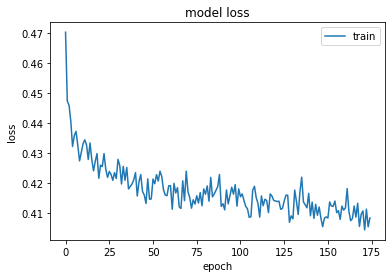

auroc:  0.7261681542974845
f1:  0.4394546912590217
threshold:  0.16626877
precision:  0.3366093366093366
recall:  0.6327944572748267
accuracy:  0.6938239159001314
specificity:  0.7081081081081081
CPU times: user 17min 28s, sys: 3min 58s, total: 21min 26s
Wall time: 5min 14s


In [71]:
### A single run w/out cross-validation
%%time
# with previous outcome added to the features
# outcome is added before scaling
seed(1)
set_random_seed(2)
model = build_model(32, 0.5, max_timestamps, n_features)
fit_model(model, 175, X_train_pad, y_train_pad, verbose=1)
y_predict = model.predict(X_test_pad)
y_test_len = [len(y) for y in y_test_list]
y_predict = truncate_prediction(y_predict, y_test_len)
y_true = np.concatenate(y_test_list)
print('auroc: ', auroc(y_predict, y_true))
f1, th = find_best_f1(y_predict, y_true)
print('f1: ', f1);
print('threshold: ', th)
precision, recall, accuracy, specificity = other_metrics(y_predict, y_true, th)
print('precision: ', precision)
print('recall: ', recall)
print('accuracy: ', accuracy)
print('specificity: ', specificity)

Epoch 1/225
1755/1755 [==============================] - 5s 3ms/step - loss: 0.4752 - binary_accuracy: 0.8179
Epoch 2/225
1755/1755 [==============================] - 2s 855us/step - loss: 0.4523 - binary_accuracy: 0.8196
Epoch 3/225
1755/1755 [==============================] - 1s 845us/step - loss: 0.4490 - binary_accuracy: 0.8179
Epoch 4/225
1755/1755 [==============================] - 1s 852us/step - loss: 0.4320 - binary_accuracy: 0.8240
Epoch 5/225
1755/1755 [==============================] - 1s 845us/step - loss: 0.4404 - binary_accuracy: 0.8219
Epoch 6/225
1755/1755 [==============================] - 2s 858us/step - loss: 0.4394 - binary_accuracy: 0.8197
Epoch 7/225
1755/1755 [==============================] - 1s 850us/step - loss: 0.4410 - binary_accuracy: 0.8184
Epoch 8/225
1755/1755 [==============================] - 1s 846us/step - loss: 0.4391 - binary_accuracy: 0.8180
Epoch 9/225
1755/1755 [==============================] - 1s 845us/step - loss: 0.4351 - binary_accuracy: 0

1755/1755 [==============================] - 1s 842us/step - loss: 0.4106 - binary_accuracy: 0.8276
Epoch 74/225
1755/1755 [==============================] - 1s 839us/step - loss: 0.4124 - binary_accuracy: 0.8306
Epoch 75/225
1755/1755 [==============================] - 1s 846us/step - loss: 0.4168 - binary_accuracy: 0.8285
Epoch 76/225
1755/1755 [==============================] - 1s 838us/step - loss: 0.4129 - binary_accuracy: 0.8259
Epoch 77/225
1755/1755 [==============================] - 1s 839us/step - loss: 0.4144 - binary_accuracy: 0.8302
Epoch 78/225
1755/1755 [==============================] - 1s 845us/step - loss: 0.4035 - binary_accuracy: 0.8298
Epoch 79/225
1755/1755 [==============================] - 1s 840us/step - loss: 0.4077 - binary_accuracy: 0.8329
Epoch 80/225
1755/1755 [==============================] - 1s 846us/step - loss: 0.4116 - binary_accuracy: 0.8285
Epoch 81/225
1755/1755 [==============================] - 1s 837us/step - loss: 0.4079 - binary_accuracy: 0.8

1755/1755 [==============================] - 2s 857us/step - loss: 0.4118 - binary_accuracy: 0.8286
Epoch 146/225
1755/1755 [==============================] - 1s 850us/step - loss: 0.3977 - binary_accuracy: 0.8343
Epoch 147/225
1755/1755 [==============================] - 1s 848us/step - loss: 0.4163 - binary_accuracy: 0.8287
Epoch 148/225
1755/1755 [==============================] - 1s 850us/step - loss: 0.4041 - binary_accuracy: 0.8325
Epoch 149/225
1755/1755 [==============================] - 1s 850us/step - loss: 0.4159 - binary_accuracy: 0.8307
Epoch 150/225
1755/1755 [==============================] - 1s 842us/step - loss: 0.4074 - binary_accuracy: 0.8326
Epoch 151/225
1755/1755 [==============================] - 1s 850us/step - loss: 0.4110 - binary_accuracy: 0.8256
Epoch 152/225
1755/1755 [==============================] - 1s 842us/step - loss: 0.4092 - binary_accuracy: 0.8307
Epoch 153/225
1755/1755 [==============================] - 1s 847us/step - loss: 0.4099 - binary_accur

Epoch 217/225
1755/1755 [==============================] - 1s 843us/step - loss: 0.4067 - binary_accuracy: 0.8312
Epoch 218/225
1755/1755 [==============================] - 1s 839us/step - loss: 0.4061 - binary_accuracy: 0.8346
Epoch 219/225
1755/1755 [==============================] - 1s 837us/step - loss: 0.4045 - binary_accuracy: 0.8311
Epoch 220/225
1755/1755 [==============================] - 1s 838us/step - loss: 0.4079 - binary_accuracy: 0.8286
Epoch 221/225
1755/1755 [==============================] - 1s 852us/step - loss: 0.3984 - binary_accuracy: 0.8373
Epoch 222/225
1755/1755 [==============================] - 1s 841us/step - loss: 0.4055 - binary_accuracy: 0.8277
Epoch 223/225
1755/1755 [==============================] - 1s 850us/step - loss: 0.4015 - binary_accuracy: 0.8289
Epoch 224/225
1755/1755 [==============================] - 1s 842us/step - loss: 0.3993 - binary_accuracy: 0.8353
Epoch 225/225
1755/1755 [==============================] - 1s 848us/step - loss: 0.4035 

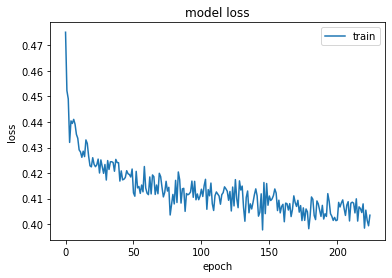

Epoch 1/225
1755/1755 [==============================] - 5s 3ms/step - loss: 0.4745 - binary_accuracy: 0.8230
Epoch 2/225
1755/1755 [==============================] - 1s 833us/step - loss: 0.4380 - binary_accuracy: 0.8261
Epoch 3/225
1755/1755 [==============================] - 1s 835us/step - loss: 0.4413 - binary_accuracy: 0.8197
Epoch 4/225
1755/1755 [==============================] - 1s 832us/step - loss: 0.4382 - binary_accuracy: 0.8271
Epoch 5/225
1755/1755 [==============================] - 1s 834us/step - loss: 0.4343 - binary_accuracy: 0.8240
Epoch 6/225
1755/1755 [==============================] - 1s 832us/step - loss: 0.4336 - binary_accuracy: 0.8266
Epoch 7/225
1755/1755 [==============================] - 1s 823us/step - loss: 0.4423 - binary_accuracy: 0.8225
Epoch 8/225
1755/1755 [==============================] - 1s 833us/step - loss: 0.4409 - binary_accuracy: 0.8212
Epoch 9/225
1755/1755 [==============================] - 1s 834us/step - loss: 0.4227 - binary_accuracy: 0

1755/1755 [==============================] - 1s 840us/step - loss: 0.4152 - binary_accuracy: 0.8326
Epoch 74/225
1755/1755 [==============================] - 1s 845us/step - loss: 0.4186 - binary_accuracy: 0.8295
Epoch 75/225
1755/1755 [==============================] - 1s 844us/step - loss: 0.4181 - binary_accuracy: 0.8322
Epoch 76/225
1755/1755 [==============================] - 1s 836us/step - loss: 0.4165 - binary_accuracy: 0.8264
Epoch 77/225
1755/1755 [==============================] - 1s 836us/step - loss: 0.4113 - binary_accuracy: 0.8316
Epoch 78/225
1755/1755 [==============================] - 1s 845us/step - loss: 0.4168 - binary_accuracy: 0.8265
Epoch 79/225
1755/1755 [==============================] - 1s 846us/step - loss: 0.4199 - binary_accuracy: 0.8248
Epoch 80/225
1755/1755 [==============================] - 1s 835us/step - loss: 0.4119 - binary_accuracy: 0.8325
Epoch 81/225
1755/1755 [==============================] - 1s 844us/step - loss: 0.4138 - binary_accuracy: 0.8

1755/1755 [==============================] - 1s 835us/step - loss: 0.4069 - binary_accuracy: 0.8358
Epoch 146/225
1755/1755 [==============================] - 1s 838us/step - loss: 0.4129 - binary_accuracy: 0.8291
Epoch 147/225
1755/1755 [==============================] - 1s 843us/step - loss: 0.4165 - binary_accuracy: 0.8295
Epoch 148/225
1755/1755 [==============================] - 1s 836us/step - loss: 0.4091 - binary_accuracy: 0.8337
Epoch 149/225
1755/1755 [==============================] - 1s 842us/step - loss: 0.4129 - binary_accuracy: 0.8301
Epoch 150/225
1755/1755 [==============================] - 1s 843us/step - loss: 0.3996 - binary_accuracy: 0.8379
Epoch 151/225
1755/1755 [==============================] - 1s 837us/step - loss: 0.4076 - binary_accuracy: 0.8344
Epoch 152/225
1755/1755 [==============================] - 1s 846us/step - loss: 0.4058 - binary_accuracy: 0.8300
Epoch 153/225
1755/1755 [==============================] - 1s 840us/step - loss: 0.4064 - binary_accur

Epoch 217/225
1755/1755 [==============================] - 1s 838us/step - loss: 0.4030 - binary_accuracy: 0.8319
Epoch 218/225
1755/1755 [==============================] - 1s 839us/step - loss: 0.4063 - binary_accuracy: 0.8303
Epoch 219/225
1755/1755 [==============================] - 1s 837us/step - loss: 0.4052 - binary_accuracy: 0.8354
Epoch 220/225
1755/1755 [==============================] - 1s 845us/step - loss: 0.4052 - binary_accuracy: 0.8360
Epoch 221/225
1755/1755 [==============================] - 1s 843us/step - loss: 0.4039 - binary_accuracy: 0.8324
Epoch 222/225
1755/1755 [==============================] - 1s 845us/step - loss: 0.4016 - binary_accuracy: 0.8314
Epoch 223/225
1755/1755 [==============================] - 1s 837us/step - loss: 0.4049 - binary_accuracy: 0.8324
Epoch 224/225
1755/1755 [==============================] - 1s 846us/step - loss: 0.4101 - binary_accuracy: 0.8326
Epoch 225/225
1755/1755 [==============================] - 1s 844us/step - loss: 0.4043 

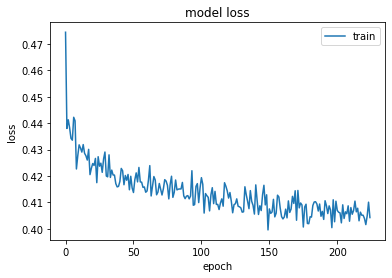

Epoch 1/225
1754/1754 [==============================] - 5s 3ms/step - loss: 0.4710 - binary_accuracy: 0.8218
Epoch 2/225
1754/1754 [==============================] - 1s 820us/step - loss: 0.4499 - binary_accuracy: 0.8220
Epoch 3/225
1754/1754 [==============================] - 1s 818us/step - loss: 0.4460 - binary_accuracy: 0.8218
Epoch 4/225
1754/1754 [==============================] - 1s 818us/step - loss: 0.4458 - binary_accuracy: 0.8233
Epoch 5/225
1754/1754 [==============================] - 1s 832us/step - loss: 0.4330 - binary_accuracy: 0.8261
Epoch 6/225
1754/1754 [==============================] - 1s 825us/step - loss: 0.4328 - binary_accuracy: 0.8222
Epoch 7/225
1754/1754 [==============================] - 1s 830us/step - loss: 0.4378 - binary_accuracy: 0.8228
Epoch 8/225
1754/1754 [==============================] - 1s 825us/step - loss: 0.4361 - binary_accuracy: 0.8234
Epoch 9/225
1754/1754 [==============================] - 1s 834us/step - loss: 0.4308 - binary_accuracy: 0

1754/1754 [==============================] - 1s 819us/step - loss: 0.4072 - binary_accuracy: 0.8327
Epoch 74/225
1754/1754 [==============================] - 1s 817us/step - loss: 0.4139 - binary_accuracy: 0.8303
Epoch 75/225
1754/1754 [==============================] - 1s 824us/step - loss: 0.4095 - binary_accuracy: 0.8324
Epoch 76/225
1754/1754 [==============================] - 1s 824us/step - loss: 0.4092 - binary_accuracy: 0.8347
Epoch 77/225
1754/1754 [==============================] - 1s 850us/step - loss: 0.4115 - binary_accuracy: 0.8312
Epoch 78/225
1754/1754 [==============================] - 1s 827us/step - loss: 0.4076 - binary_accuracy: 0.8311
Epoch 79/225
1754/1754 [==============================] - 1s 819us/step - loss: 0.4114 - binary_accuracy: 0.8335
Epoch 80/225
1754/1754 [==============================] - 1s 834us/step - loss: 0.4060 - binary_accuracy: 0.8312
Epoch 81/225
1754/1754 [==============================] - 1s 825us/step - loss: 0.4067 - binary_accuracy: 0.8

1754/1754 [==============================] - 1s 836us/step - loss: 0.4082 - binary_accuracy: 0.8258
Epoch 146/225
1754/1754 [==============================] - 1s 830us/step - loss: 0.4028 - binary_accuracy: 0.8351
Epoch 147/225
1754/1754 [==============================] - 1s 829us/step - loss: 0.4073 - binary_accuracy: 0.8310
Epoch 148/225
1754/1754 [==============================] - 1s 833us/step - loss: 0.4103 - binary_accuracy: 0.8318
Epoch 149/225
1754/1754 [==============================] - 1s 827us/step - loss: 0.4067 - binary_accuracy: 0.8287
Epoch 150/225
1754/1754 [==============================] - 1s 823us/step - loss: 0.4046 - binary_accuracy: 0.8347
Epoch 151/225
1754/1754 [==============================] - 1s 841us/step - loss: 0.4008 - binary_accuracy: 0.8327
Epoch 152/225
1754/1754 [==============================] - 1s 833us/step - loss: 0.4093 - binary_accuracy: 0.8289
Epoch 153/225
1754/1754 [==============================] - 1s 835us/step - loss: 0.4010 - binary_accur

Epoch 217/225
1754/1754 [==============================] - 1s 838us/step - loss: 0.3984 - binary_accuracy: 0.8328
Epoch 218/225
1754/1754 [==============================] - 1s 832us/step - loss: 0.3979 - binary_accuracy: 0.8338
Epoch 219/225
1754/1754 [==============================] - 1s 829us/step - loss: 0.4018 - binary_accuracy: 0.8312
Epoch 220/225
1754/1754 [==============================] - 1s 834us/step - loss: 0.4028 - binary_accuracy: 0.8297
Epoch 221/225
1754/1754 [==============================] - 1s 824us/step - loss: 0.4026 - binary_accuracy: 0.8303
Epoch 222/225
1754/1754 [==============================] - 1s 828us/step - loss: 0.4017 - binary_accuracy: 0.8317
Epoch 223/225
1754/1754 [==============================] - 1s 825us/step - loss: 0.4001 - binary_accuracy: 0.8300
Epoch 224/225
1754/1754 [==============================] - 1s 837us/step - loss: 0.4047 - binary_accuracy: 0.8301
Epoch 225/225
1754/1754 [==============================] - 1s 842us/step - loss: 0.3996 

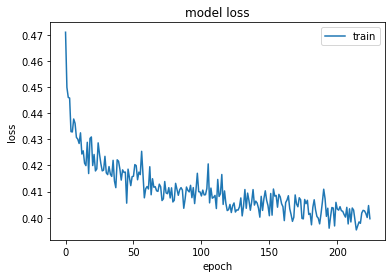

Epoch 1/225
1754/1754 [==============================] - 5s 3ms/step - loss: 0.4683 - binary_accuracy: 0.8215
Epoch 2/225
1754/1754 [==============================] - 1s 850us/step - loss: 0.4526 - binary_accuracy: 0.8170
Epoch 3/225
1754/1754 [==============================] - 1s 852us/step - loss: 0.4507 - binary_accuracy: 0.8134
Epoch 4/225
1754/1754 [==============================] - 1s 852us/step - loss: 0.4507 - binary_accuracy: 0.8165
Epoch 5/225
1754/1754 [==============================] - 2s 857us/step - loss: 0.4322 - binary_accuracy: 0.8267
Epoch 6/225
1754/1754 [==============================] - 1s 847us/step - loss: 0.4401 - binary_accuracy: 0.8210
Epoch 7/225
1754/1754 [==============================] - 1s 851us/step - loss: 0.4387 - binary_accuracy: 0.8203
Epoch 8/225
1754/1754 [==============================] - 2s 863us/step - loss: 0.4451 - binary_accuracy: 0.8163
Epoch 9/225
1754/1754 [==============================] - 2s 865us/step - loss: 0.4305 - binary_accuracy: 0

1754/1754 [==============================] - 1s 844us/step - loss: 0.4173 - binary_accuracy: 0.8259
Epoch 74/225
1754/1754 [==============================] - 1s 835us/step - loss: 0.4231 - binary_accuracy: 0.8261
Epoch 75/225
1754/1754 [==============================] - 1s 830us/step - loss: 0.4205 - binary_accuracy: 0.8250
Epoch 76/225
1754/1754 [==============================] - 1s 836us/step - loss: 0.4180 - binary_accuracy: 0.8293
Epoch 77/225
1754/1754 [==============================] - 1s 830us/step - loss: 0.4213 - binary_accuracy: 0.8256
Epoch 78/225
1754/1754 [==============================] - 1s 831us/step - loss: 0.4159 - binary_accuracy: 0.8277
Epoch 79/225
1754/1754 [==============================] - 1s 826us/step - loss: 0.4162 - binary_accuracy: 0.8256
Epoch 80/225
1754/1754 [==============================] - 1s 829us/step - loss: 0.4178 - binary_accuracy: 0.8259
Epoch 81/225
1754/1754 [==============================] - 1s 852us/step - loss: 0.4204 - binary_accuracy: 0.8

1754/1754 [==============================] - 1s 839us/step - loss: 0.4177 - binary_accuracy: 0.8237
Epoch 146/225
1754/1754 [==============================] - 1s 838us/step - loss: 0.4137 - binary_accuracy: 0.8259
Epoch 147/225
1754/1754 [==============================] - 1s 838us/step - loss: 0.4059 - binary_accuracy: 0.8290
Epoch 148/225
1754/1754 [==============================] - 1s 839us/step - loss: 0.4206 - binary_accuracy: 0.8293
Epoch 149/225
1754/1754 [==============================] - 1s 833us/step - loss: 0.4097 - binary_accuracy: 0.8289
Epoch 150/225
1754/1754 [==============================] - 1s 833us/step - loss: 0.4128 - binary_accuracy: 0.8248
Epoch 151/225
1754/1754 [==============================] - 1s 835us/step - loss: 0.4097 - binary_accuracy: 0.8291
Epoch 152/225
1754/1754 [==============================] - 1s 837us/step - loss: 0.4125 - binary_accuracy: 0.8240
Epoch 153/225
1754/1754 [==============================] - 1s 837us/step - loss: 0.4071 - binary_accur

Epoch 217/225
1754/1754 [==============================] - 1s 832us/step - loss: 0.4167 - binary_accuracy: 0.8263
Epoch 218/225
1754/1754 [==============================] - 1s 830us/step - loss: 0.4136 - binary_accuracy: 0.8263
Epoch 219/225
1754/1754 [==============================] - 1s 833us/step - loss: 0.4134 - binary_accuracy: 0.8275
Epoch 220/225
1754/1754 [==============================] - 1s 840us/step - loss: 0.4155 - binary_accuracy: 0.8264
Epoch 221/225
1754/1754 [==============================] - 1s 835us/step - loss: 0.4056 - binary_accuracy: 0.8327
Epoch 222/225
1754/1754 [==============================] - 1s 838us/step - loss: 0.4097 - binary_accuracy: 0.8310
Epoch 223/225
1754/1754 [==============================] - 1s 840us/step - loss: 0.4076 - binary_accuracy: 0.8301
Epoch 224/225
1754/1754 [==============================] - 1s 837us/step - loss: 0.4001 - binary_accuracy: 0.8320
Epoch 225/225
1754/1754 [==============================] - 1s 841us/step - loss: 0.4059 

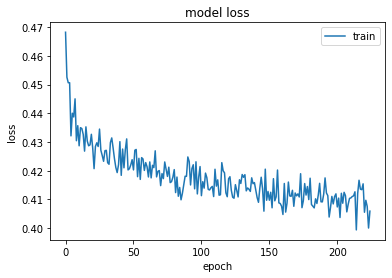

Epoch 1/225
1754/1754 [==============================] - 5s 3ms/step - loss: 0.4763 - binary_accuracy: 0.8161
Epoch 2/225
1754/1754 [==============================] - 1s 824us/step - loss: 0.4518 - binary_accuracy: 0.8203
Epoch 3/225
1754/1754 [==============================] - 1s 821us/step - loss: 0.4489 - binary_accuracy: 0.8185
Epoch 4/225
1754/1754 [==============================] - 1s 825us/step - loss: 0.4450 - binary_accuracy: 0.8184
Epoch 5/225
1754/1754 [==============================] - 1s 824us/step - loss: 0.4467 - binary_accuracy: 0.8132
Epoch 6/225
1754/1754 [==============================] - 1s 830us/step - loss: 0.4419 - binary_accuracy: 0.8193
Epoch 7/225
1754/1754 [==============================] - 1s 827us/step - loss: 0.4389 - binary_accuracy: 0.8186
Epoch 8/225
1754/1754 [==============================] - 1s 825us/step - loss: 0.4342 - binary_accuracy: 0.8225
Epoch 9/225
1754/1754 [==============================] - 1s 838us/step - loss: 0.4334 - binary_accuracy: 0

1754/1754 [==============================] - 1s 819us/step - loss: 0.4188 - binary_accuracy: 0.8284
Epoch 74/225
1754/1754 [==============================] - 1s 823us/step - loss: 0.4157 - binary_accuracy: 0.8293
Epoch 75/225
1754/1754 [==============================] - 1s 819us/step - loss: 0.4155 - binary_accuracy: 0.8267
Epoch 76/225
1754/1754 [==============================] - 1s 824us/step - loss: 0.4157 - binary_accuracy: 0.8279
Epoch 77/225
1754/1754 [==============================] - 1s 823us/step - loss: 0.4167 - binary_accuracy: 0.8223
Epoch 78/225
1754/1754 [==============================] - 1s 820us/step - loss: 0.4132 - binary_accuracy: 0.8256
Epoch 79/225
1754/1754 [==============================] - 1s 818us/step - loss: 0.4133 - binary_accuracy: 0.8252
Epoch 80/225
1754/1754 [==============================] - 1s 820us/step - loss: 0.4203 - binary_accuracy: 0.8171
Epoch 81/225
1754/1754 [==============================] - 1s 818us/step - loss: 0.4195 - binary_accuracy: 0.8

1754/1754 [==============================] - 1s 824us/step - loss: 0.4177 - binary_accuracy: 0.8250
Epoch 146/225
1754/1754 [==============================] - 1s 818us/step - loss: 0.4129 - binary_accuracy: 0.8294
Epoch 147/225
1754/1754 [==============================] - 1s 817us/step - loss: 0.4088 - binary_accuracy: 0.8296
Epoch 148/225
1754/1754 [==============================] - 1s 816us/step - loss: 0.4148 - binary_accuracy: 0.8269
Epoch 149/225
1754/1754 [==============================] - 1s 820us/step - loss: 0.4163 - binary_accuracy: 0.8220
Epoch 150/225
1754/1754 [==============================] - 1s 816us/step - loss: 0.4123 - binary_accuracy: 0.8257
Epoch 151/225
1754/1754 [==============================] - 1s 822us/step - loss: 0.4090 - binary_accuracy: 0.8270
Epoch 152/225
1754/1754 [==============================] - 1s 817us/step - loss: 0.4136 - binary_accuracy: 0.8288
Epoch 153/225
1754/1754 [==============================] - 1s 825us/step - loss: 0.4064 - binary_accur

Epoch 217/225
1754/1754 [==============================] - 1s 821us/step - loss: 0.4095 - binary_accuracy: 0.8283
Epoch 218/225
1754/1754 [==============================] - 1s 822us/step - loss: 0.4106 - binary_accuracy: 0.8270
Epoch 219/225
1754/1754 [==============================] - 1s 822us/step - loss: 0.4101 - binary_accuracy: 0.8251
Epoch 220/225
1754/1754 [==============================] - 1s 815us/step - loss: 0.4150 - binary_accuracy: 0.8278
Epoch 221/225
1754/1754 [==============================] - 1s 817us/step - loss: 0.4092 - binary_accuracy: 0.8319
Epoch 222/225
1754/1754 [==============================] - 1s 819us/step - loss: 0.4029 - binary_accuracy: 0.8295
Epoch 223/225
1754/1754 [==============================] - 1s 822us/step - loss: 0.4120 - binary_accuracy: 0.8262
Epoch 224/225
1754/1754 [==============================] - 1s 821us/step - loss: 0.4085 - binary_accuracy: 0.8274
Epoch 225/225
1754/1754 [==============================] - 1s 826us/step - loss: 0.4079 

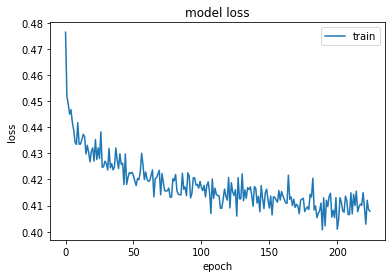

In [79]:
## Run 5-fold cross-validation to get average performance characteristics
unit = 32
ratio = 0.5
epoch = 225
(auroc_list, other_metric_list) = kfold_validation(unit, ratio, epoch, X_train_transformed, y_train, 'patient-id', verbose=1)

In [88]:
## other_metric_list has precision, recall, accuracy, specificity, f1, threshold for metrics
ave_prec = np.mean([x[0] for x in other_metric_list])
print("average precision:" + str(ave_prec))

ave_recall = np.mean([x[1] for x in other_metric_list])
print("average recall:" + str(ave_recall))

ave_specificity = np.mean([x[3] for x in other_metric_list])
print("average specificity:" + str(ave_specificity))

ave_f1 = np.mean([x[4] for x in other_metric_list])
print("average F1:" + str(ave_f1))

average precision:0.36352633931786027
average recall:0.5886624350134049
average specificity:0.7720560876428268
average F1:0.44888757540286245


In [91]:
max_f1 = np.max([x[4] for x in other_metric_list])
print("max F1: " + str(max_f1))

max F1: 0.48940269749518306


In [89]:
## Average metrics performance
print("unit: %d\tepoch: %d\tauroc_mean: %f\tauroc_std: %f"  % (unit, epoch, np.mean(auroc_list), np.std(auroc_list)))

unit: 32	epoch: 225	auroc_mean: 0.728596	auroc_std: 0.014336


In [76]:
auroc_list

[0.7077088055372767,
 0.7433450644628484,
 0.7229418636613524,
 0.7462190124409652,
 0.7227889553045588]